<a href="https://colab.research.google.com/github/victorcionca/5gslicing/blob/main/slice_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5G infrastructure simulator

Simulates the RAN and TN of a 5G infrastructure, including data centres for hosting NFs of the core, and the MEC.

## Related work

Understanding QoS Applicability in 5G Transport Networks
Cominardi et al, IEEE BMSB 2018

5GEN: A tool to generate 5G infrastructure graphs
Martin-Perez et al, IEEE CSCN 2019

Modeling MEC deployments for low latency multimedia services
Martin-Perez et al, IEEE T Broadcasting 2019

# Algorithm

* simulate a demographic
  * a mixture of high and regular density urban and rural regions
* deploy RUs in each area cell based on 3GPP TR 38.913 coverage recommendations
  * dense urban: ISD 200m
  * urban: ISD 500m
  * rural: ISD 1700m
* UE density is obtained from NGMN 5G white paper
  * dense urban is 2500/km2
  * sub-urban 50+ everywhere is 400/km2
  * rural 50+ everywhere is 100/km2

In [1]:
# Algorithm configuration
config = {
    'area_width': 50, # in kms
    'area_cell_width': 0.1, # Width of an area cell; not to be confused with radio cell
    'pdf_centre': (25,25), # Centre of the density function, in kilometres
    'pdf_width': 5, # Width (stddev) of density function, in kilometres
    'high_density': 0.6, # Ratio of population living in highly dense urban
    'urban': 0.39, # Ratio of population living in regular urban area
    'rural': 0.01, # Ratio of population living in rural area
    'isd_high': 0.2, # 200m high density ISD, per 3GPP
    'isd_urban': 0.5,
    'isd_rural': 1.7,
    'ue_density_high': 2500, # UEs per km2 in dense areas
    'ue_density_med': 400, # urban areas
    'ue_density_low': 100, # rural areas
}

## Demographic

The demographic is simulated by creating a large region and defining a 2D density function on top of it.

Options to consider
* allow the overlaying of several density functions to create more diverse scenarios

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import erf

In [3]:
# The value of each cell will be the PDF at the distance from the PDF centre
def dist_from_pdf_centre(cell_idx, num_cells):
  """Returns the distance (kms) from x,y to the PDF centre (in config)"""
  cell_col = cell_idx % np.sqrt(num_cells)
  cell_row = cell_idx // np.sqrt(num_cells)
  cell_x = 0.5*(2*cell_col+1)*config['area_cell_width']
  cell_y = 0.5*(2*cell_row+1)*config['area_cell_width']
  c_x, c_y = config['pdf_centre']
  return np.sqrt((c_x-cell_x)**2 + (c_y-cell_y)**2)

In [4]:
def generate_demographic():
  """
  Generate a deployment area made up of cells of configured width.
  Each cell will be configured with a population density, one of three 
  values: high density (3), common urban (2), rural (1).

  ### Returns:
  
  matrix with each cell containing its index
  matrix with each cell containing the population density
  """
  # Define the area as a matrix of cells of configured width
  row_cells = int(np.ceil(config['area_width']/config['area_cell_width']))
  # Need to round up to next square
  num_cells = int(row_cells**2)
  area_cells = np.array(range(num_cells))
  area_cells = area_cells.reshape(row_cells, row_cells)
  # Compute the PDF for each cell, based on its distance from the centre
  pdfs = norm.pdf(dist_from_pdf_centre(area_cells, num_cells), 0, config['pdf_width'])
  # Compute the thresholds for population density, based on Quantile function
  # --> P(population density > Threshold) is CDF(x) = Threshold
  # --> we want the threshold so CDF-1(x) which is quantile function
  ppf_high = norm.ppf(config['high_density'], 0, config['pdf_width'])
  ppf_urban = abs(norm.ppf(config['high_density'] + config['urban'],
                              0, config['pdf_width']))
  # Then convert those values into PDFs
  thresh_high = norm.pdf(ppf_high, 0, config['pdf_width'])
  thresh_urban = norm.pdf(ppf_urban, 0, config['pdf_width'])
  # Discretize the PDF based on the thresholds
  pdfs[pdfs >= thresh_high] = 3
  pdfs[(pdfs >= thresh_urban) & (pdfs < 1)] = 2
  pdfs[pdfs < thresh_urban] = 1
  return area_cells, pdfs

In [5]:
area_cells, pdfs = generate_demographic()

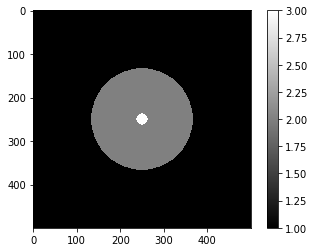

In [6]:
plt.imshow(pdfs, cmap='gray', interpolation='None')
plt.colorbar()

## RU deployment

* perform the deployment incrementally, as follows, assuming that the population
density increases gradually
* first deploy RUs in the cells with density >= rural, following the rural ISD
* then clear the urban areas, and deploy following the urban ISD in cells with density >= urban
* repeat for high density.

In [7]:
def deploy_rus(area_cells, pdfs):
  """
  Deploys RUs based on the ISD defined in the configuration.
  Returns a matrix of same shape as area cells where each element represents
  an area cell and is 1 if an RU is deployed, otherwise 0.
  """
  ru_cells = np.zeros_like(area_cells)
  # Deploy in cells >= rural with rural ISD
  isd_rural_cells = int(config['isd_rural']/config['area_cell_width'])
  ru_cells[0:len(area_cells):isd_rural_cells,
         np.arange(0,len(area_cells), isd_rural_cells),] = 1
  # Clear the urban areas and higher
  ru_cells[pdfs >= 2] = 0
  # Deploy
  isd_urban_cells = int(config['isd_urban']/config['area_cell_width'])
  tmp_urban_base = pdfs >= 2
  tmp_urban_cells = np.zeros_like(area_cells)
  tmp_urban_cells[0:len(area_cells):isd_urban_cells, np.arange(0, len(area_cells), isd_urban_cells)] = 1
  ru_cells[np.array((tmp_urban_base & tmp_urban_cells), dtype=np.bool)] = 1
  # Clear the high density areas
  ru_cells[pdfs == 3] = 0
  # Deploy
  isd_high_cells = int(config['isd_high']/config['area_cell_width'])
  tmp_high_base = pdfs == 3
  tmp_high_cells = np.zeros_like(area_cells)
  tmp_high_cells[0:len(area_cells):isd_high_cells, np.arange(0, len(area_cells), isd_high_cells)] = 1
  ru_cells[np.array((tmp_high_base & tmp_high_cells), dtype=np.bool)] = 1
  return ru_cells

In [8]:
ru_cells = deploy_rus(area_cells, pdfs)

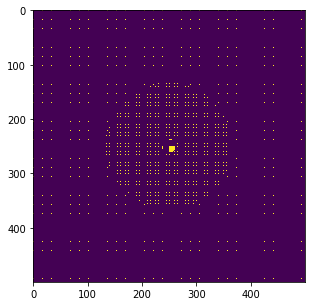

In [9]:
plt.figure(figsize=(5,5))
plt.imshow(ru_cells, interpolation='None')

# Transport network

## Cell traffic

To be able to determine multiplexing gains we need a model of the data rate distribution per cell.
We derive this using a "User Traffic Mix" model that contains a combination of
* web browsing
* file transfer
* video streaming
* VoIP
* online gaming.

### Web browsing traffic model

Based on Qi et al, "Quantifying Data Rate and Bandwidth Requirements for Immersive 5G Experience", IEEE ICC2016 Workshops W09.


In [10]:
a_up = 2*2**20
a_low = 100
sigma = 1.37
mu = 8.35
T_wb = 30
K = 1/(np.sqrt(2*np.pi)*T_wb*sigma\
      *(norm.cdf((np.log(a_up) - mu)/sigma) - norm.cdf((np.log(a_low) - mu)/sigma)))

def mu_bar(r):
  return mu/r - sigma**2/(T_wb*r**2)

def sigma_bar(r):
  return sigma/r

def K_bar(r):
  return np.sqrt(2*np.pi)*sigma_bar(r)*K\
          *np.exp(- ( (mu/r)**2 - ( (T_wb*r*mu-sigma**2) / (T_wb*r**2) )**2) / (2*(sigma/r)**2))

def web_a(r):
  return (np.log(a_up)/r - mu_bar(r))/sigma_bar(r)

def web_b(r):
  return (np.log(a_low)/r - mu_bar(r))/sigma_bar(r)

def web_data_rate_pdf(r):
  inner_top = (norm.pdf(web_a(r))-norm.pdf(web_b(r)))
  inner_bot = (norm.cdf(web_a(r))-norm.cdf(web_b(r)))
  return K_bar(r)*(mu_bar(r) + sigma_bar(r)*(inner_top/inner_bot))

Text(0, 0.5, 'PDF')

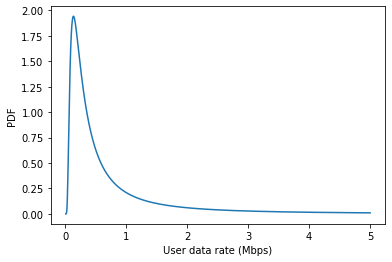

In [11]:
web_rate = np.linspace(0.01,5, 1000)
_=plt.plot(web_rate, web_data_rate_pdf(web_rate))
#_=x_ticks = [0,0.01,0.02,0.03,0.04,0.05]
#_=plt.xticks([r*(2**20)/8 for r in x_ticks], x_ticks)
plt.xlabel('User data rate (Mbps)')
plt.ylabel('PDF')

#### MC simulation of the same

In [12]:
from scipy.stats import lognorm

In [13]:
def lognormal_pdf(x, sigma, mu):
  return 1/(np.sqrt(2*np.pi)*sigma*x)*np.exp(-((np.log(x)-mu)**2)/(2*sigma**2))

def lognormal_cdf(x, sigma, mu):
  return 0.5+0.5*erf((np.log(x)-mu)/(np.sqrt(2)*sigma))
  
def trunc_lognormal_pdf(x, a, b, sigma, mu):
  top = lognormal_pdf(x, sigma, mu)
  bot = norm.cdf((np.log(b)-mu)/sigma) - norm.cdf((np.log(a)-mu)/sigma)
  return top/bot

In [14]:
# Truncated log-normal sampling
def trunc_lognormal_sample(a,b,mu,sigma):
  lncdf_a = lognormal_cdf(a,sigma,mu)
  lncdf_b = lognormal_cdf(b,sigma,mu)
  cdf = (lncdf_b - lncdf_a)*np.random.random() + lncdf_a
  ppf_norm = norm.ppf(cdf, mu, sigma)
  return np.exp(ppf_norm)

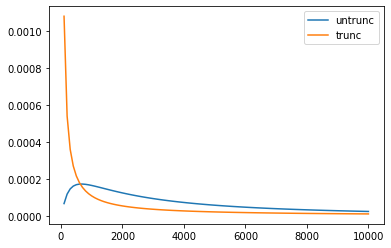

In [15]:
x = np.linspace(100,10000,100)
plt.plot(x, lognormal_pdf(x, 1.37, 8.37), label='untrunc')
plt.plot(x, trunc_lognormal_pdf(x, 100, 2**20, 25032, 10710), label='trunc')
plt.legend()

In [16]:
trunc_lognormal_sample(100, 2**20, 25032, 10710)

152391.6829157939

In [17]:
from scipy.stats import expon

web_data_rates = []
for i in range(int(1e6)):
  # Draw a packet size from lognormal distr
  pkt_size = trunc_lognormal_sample(100, 2*2**20, 25032, 10710)
  # Draw a waiting time
  wait_time = expon.rvs(30)
  web_data_rates.append(pkt_size/wait_time)

Text(0.5, 0, 'Data rate (Bps)')

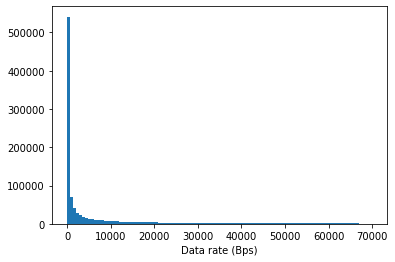

In [18]:
_=plt.hist(web_data_rates, bins=100)
plt.xlabel('Data rate (Bps)')

### File transfer traffic

Take the NGMN model, where
* the file size is a truncated log-normal distribution with mean = 2MB, Stddev = 0.722MB, Max = 5MB
* reading time is exponentially distributed with mean = 180s

#### MC simulation

In [19]:
ftp_data_rates = []
for i in range(int(1e6)):
  # Draw a packet size from lognormal distr
  pkt_size = trunc_lognormal_sample(1, 5*2**20, 2**20*0.722, 2*2**20)
  # Draw a waiting time
  wait_time = expon.rvs(180)
  ftp_data_rates.append(pkt_size/wait_time)

Text(0.5, 0, 'Data rate (Bps)')

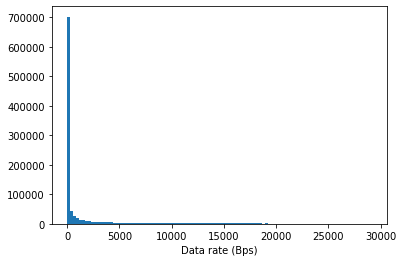

In [20]:
_=plt.hist(ftp_data_rates, bins=100)
plt.xlabel('Data rate (Bps)')

### Video streaming

Frames are broken into packets that are Pareto distributed.

The interval between frames is also Pareto distributed.

In [21]:
def trunc_pareto_pdf(x, lo, hi, alpha):
  return alpha*lo**alpha*(x**(-alpha-1))/(1-(lo/hi)**alpha)

def pareto_cdf(x, m, alpha):
  return 1 - (m/x)**alpha

def bounded_pareto_sample(lo, hi, alpha):
  x = np.random.random()
  return (-(x*hi**alpha-x*lo**alpha-hi**alpha)/(hi**alpha*lo**alpha))**(-1/alpha)

#### MC simulation

In [54]:
min_vid_pkt = 560/8*2**10 # 560KBs #3.32*2**20  # 3.32 MB
max_vid_pkt = 4.2/8*2**20 # 4.2MBs # 20.75*2**20 # 20.75 MB
vid_data_rates = []
for i in range(int(1e6)):
  # Draw a packet size from lognormal distr
  pkt_size = bounded_pareto_sample(min_vid_pkt, max_vid_pkt, 1.67)
  # Draw a waiting time
  wait_time = bounded_pareto_sample(0.832*1e-3, 5.2*1e-3, 1.67)
  vid_data_rates.append(pkt_size/wait_time)

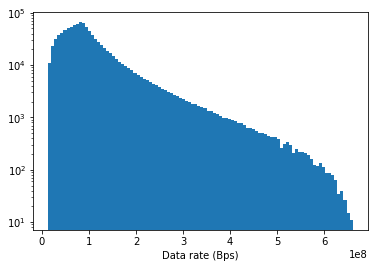

In [55]:
_=plt.hist(vid_data_rates, bins=100)
plt.xlabel('Data rate (Bps)')
plt.yscale('log')

The METIS model for Non Real Time Video Traffic is as FTP traffic with 50Mbps rate and 30fps.

This amounts to 1.66Mb file size and 0.033s mean reading time.

In [60]:
vid_data_rates_metis = []
pkt_size = 1.66*2**20 # MB per second
mean_reading_time = 0.033 # 33ms mean reading time
for i in range(int(1e6)):
  # Draw a waiting time
  wait_time = expon.rvs(mean_reading_time)
  vid_data_rates_metis.append(pkt_size/wait_time)

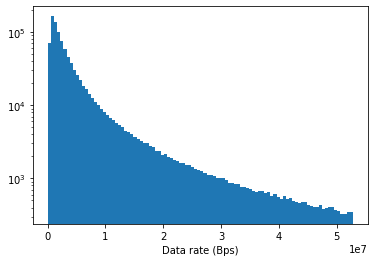

In [61]:
_=plt.hist(vid_data_rates_metis, bins=100)
plt.xlabel('Data rate (Bps)')
plt.yscale('log')

### Mixing traffic

* take the UE density brackets from NGMN:
  * dense urban 2500UE/km2
  * suburban 400UE/km2
  * rural 100UE/km2


#### Load estimation

A user places a certain demand on the network from the application level. This is modelled with one of the traffic models in the previous sections.

At the same time, based on the signal quality experienced by the user (which depends on the location of the user in the network and the path loss model) the BS will allocate an MCS, which will determine the maximum data rate attainable.

Therefore the user load will be the minimum between the application traffic model and the maximum data rate usable.
* we don't consider scheduling of resources; we cap the maximum usage over all users to the BS capacity.

In the following we determine the maximum data rate attainable by the UE starting from the ue-bs distance and employing a path loss model, and a mapping between SINR and MCS. We further assume there is no interference.

In [24]:
def path_loss_old(ue_dist):
  """
  Computes the path loss at the given distance (km).
  Based on 36.492
  """
  return 40*(1-4e-3*bs_height)*np.log10(ue_dist)\
          -18*np.log10(bs_height)+21*np.log10(carrier_f)+80

In [25]:
def path_loss_5g(ue_dist):
  """
  Based on Haneda et al 5G 3gpp-like channel models... VTC 2016
  The CI (Close-In) model.
  """
  # Calculate the probability of LoS
  p_los = np.minimum(18/ue_dist,1)*(1-np.exp(-ue_dist/63)+np.exp(-ue_dist/63))
  # Parameters of CI-model
  n = np.zeros_like(p_los)
  SF = np.zeros_like(p_los)
  # Path loss exp
  n[p_los >= 0.5] = 2.0 # High prob of LoS
  n[p_los < 0.5] = 3.0
  # Shadow-fading stddev
  SF[p_los >= 0.5] = 4.1 # High prob of LoS
  SF[p_los < 0.5] = 6.8
  fspl1m = 20*np.log10(4*np.pi*3.8*1e9/299792458)
  shadow = norm.rvs(scale=SF)
  return fspl1m + 10*n*np.log10(ue_dist) + shadow

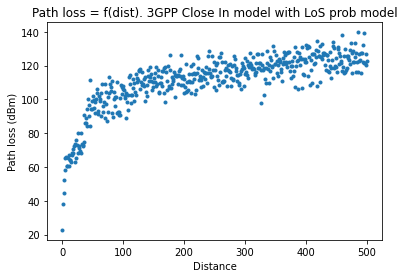

In [26]:
ue_dist = np.linspace(0.1,500,500)
plt.plot(ue_dist, path_loss_5g(ue_dist), '.')
plt.xlabel('Distance')
plt.ylabel('Path loss (dBm)')
_=plt.title('Path loss = f(dist). 3GPP Close In model with LoS prob model')

In [27]:
# The following map of SINR to MCS from
#     Ramos et al, "Mapping between...", WPMC 2019
sinr_mcs_map = [
    -4.63,-3.615,-2.6,-1.36,-0.12,1.17,2.26,3.595,
    4.73,6.13,7.53,8.1,8.67,9.995,11.32,12.78,14.24,14.725,15.21,16.92,18.3,
    19.975,21.32,22.395,23.47,25.98,28.49,31.545,34.6
]

In [28]:
def get_mcs_index(sinr):
  """Returns the MCS index that is supported at the given SINR"""
  mcs = 0
  for s in sinr_mcs_map[1:]:
    if sinr < s: return mcs
    mcs += 1
  return len(sinr_mcs_map)-1

In [29]:
# Table 5.1.3.1-1 from 38.214
# Modulation order and target code rate x1024 for mcs index 
mcs_index_tbl = [
    (2,120),(2,157),(2,193),(2,251),(2,308),(2,379),(2,449),(2,526),(2,602),(2,679),
    (4,340),(4,378),(4,434),(4,490),(4,553),(4,616),(4,658),(6,438),(6,466),(6,517),
    (6,567),(6,616),(6,666),(6,719),(6,772),(6,822),(6,873),(6,910),(6,948)
]

In [30]:
def data_rate(mod_ord, code_rate):
  """
  Estimates data rate for given modulation order and code rate
  Based on 5G xhaul D21
  """
  return np.log2(mod_ord)*code_rate\
          *1.33\
          *1e3\
          *14\
          *5*1200\
          *8

In [31]:
def data_rate_5g(mod_ord, code_rate):
  """
  5G NR UE data rate, based on 38.306 4.1.2
  Assuming no carrier aggregation, 100MHz channel, 4 MIMO layers.
  """
  mu = 2 # Use FR1 (<6GHz), BW 100MHz so numerology (mu) = 2 (60KHz SCS)
  Tu = 1e-3/(14*2**mu) # average OFDM symbol duration
  N_prb = 132 # Based on 38.101-2 table 5.3.2-1
  oh = 0.14 # Overhead for FR1 DL
  layers = 4 # MIMO
  return 1e-6*layers*mod_ord*(code_rate/1024)*N_prb*12*(1-oh)/Tu

In [32]:
def get_ue_data_rate(dist):
  """
  Determine the maximum data rate to be expected at the given distance.

  First calculates the SINR using the path loss model, assuming 
  BS EIRP of 60dBm and UE EIRP of 40dBm (so 100dBm total gain).
  Then determines the MCS index from the SINR, and computes the data rate.
  """
  sinr = 100 - path_loss_5g(dist)
  if isinstance(dist, np.ndarray):
    return [data_rate_5g(*mcs_index_tbl[get_mcs_index(s)]) for s in sinr]
  else:
    return data_rate_5g(*mcs_index_tbl[get_mcs_index(sinr)])

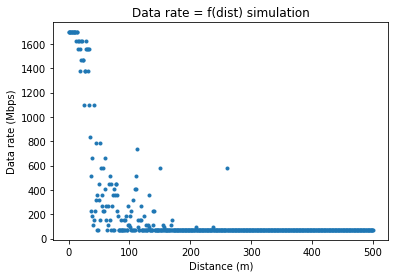

In [33]:
plt.plot(ue_dist, get_ue_data_rate(ue_dist), '.')
plt.xlabel('Distance (m)')
plt.ylabel('Data rate (Mbps)')
_= plt.title('Data rate = f(dist) simulation')

#### Total cell load estimation

MC simulation of the traffic load
* select users (positions) from a cell
* for each, sample an application type out of the three
* sample a traffic demand from the application traffic model
* determine for the user's position the distance relative to the antenna
* determine the maximum data rate attainable
* add to the total load the min between max att and user demand.

In [34]:
from scipy.stats import poisson

# Sample user positions.
# From a Poisson Point Process on the circle with radius of the cell
def sample_users(user_density, cell_radius):
  """
  Creates a generator of user positions from a Poisson Point Process with
  lambda set to user_density.
  Returns the distance from the cell centre
  """
  lbda = np.pi*cell_radius**2*user_density
  num_users = poisson.rvs(lbda)
  for i in range(num_users):
    yield cell_radius*np.random.rand()
  return

In [64]:
def generate_load(user_density, cell_radius):
  total_load = 0
  load = []
  traffic_types = [web_data_rates, ftp_data_rates, vid_data_rates_metis]
  num_users = 0
  for d in sample_users(user_density, cell_radius):
    # Sample a traffic model
    traffic_type = traffic_types[np.random.randint(0,3)]
    ue_demand = traffic_type[np.random.randint(0, len(traffic_type))]
    max_data_rate = get_ue_data_rate(d) # This is in Mbps so must be converted
    this_load = min(ue_demand*8, max_data_rate*2**20)
    total_load += this_load
    num_users += 1
  return total_load/(2**20), num_users

In [65]:
# Dense urban cell load distribution
cell_load_dense = [generate_load(config['ue_density_high'],config['isd_high']) for i in range(1000)]
# Urban cell load distribution
cell_load_urban = [generate_load(config['ue_density_med'],config['isd_urban']) for i in range(1000)]
# Rural cell load distribution
cell_load_rural = [generate_load(config['ue_density_low'],config['isd_rural']) for i in range(1000)]

In [70]:
def ecdf(data, label):
  """
  Computes and plots the ECDF of the data.
  Returns:
  the 95th percentile of the data
  the median of the data
  the 5th percentile of the data
  """
  data_cpy = list(data)
  data_cpy.sort()
  prob = np.arange(len(data))/len(data)
  plt.plot(data_cpy, prob, label=label)
  p95 = np.argmin(np.abs(prob - 0.95))
  p50 = np.argmin(np.abs(prob - 0.5))
  p05 = np.argmin(np.abs(prob - 0.05))
  return data_cpy[p95], data_cpy[p50], data_cpy[p05]

Text(0, 0.5, 'ECDF')

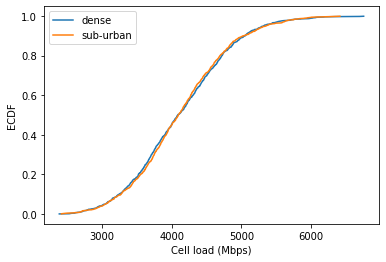

In [71]:
dense_stats = ecdf(list(zip(*cell_load_dense))[0], "dense")
urban_stats = ecdf(list(zip(*cell_load_urban))[0], "sub-urban")
#ecdf(list(zip(*cell_load_rural))[0], "rural")
plt.legend()
plt.xlabel('Cell load (Mbps)')
plt.ylabel('ECDF')

In [72]:
dense_stats

(5321.495380504615, 4088.677811952472, 3053.5304829401484)

In [73]:
urban_stats

(5348.849916494804, 4097.392964442439, 3057.397988034376)

According to 5GXhaul we will use the 95th percentile cell load when calculating transport capacity.

## Statistical multiplexing while aggregating multiple cells

According to 5GXhaul D2.1 and Bartelt et al "Fronthau lfor a Flexible Centralization in Cloud Radio Access Networks", Wiley&Sons 2017.

Provisioning of transport capacity that aggregates K number of cells can be done as follows, while accounting for 95% percent of the cell load:
1. provision for $KQ(95th,1)$ so for K times the 95-th percentile of the cell load, which would assume that all cells will have 95th percentile load at the same time
2. provision for $Q(95th,K)$, assuming that the loads in different cells are independent of each other.

Considering this, the transport capacity for aggregating K cells will be ``max(peak, k x busy_hour)`` (according to NGMN LTE dimensioning.

In [76]:
# Will use MC simulations to sample the 95-th percentile load of K cells
# assuming independent loads
def aggregate_mux(k, cell_load):
  """
  Parameters
  k   --  number of cells to aggregate
  cell_load   -- distribution of cell load
  Returns
  Capacity required to maintain 95-th percentile of aggregatd load
  """
  total_load = []
  for s in range(int(1e4)):
    agg_load = sum(cell_load[np.random.randint(0,len(cell_load))]
                   for i in range(k))
    total_load.append(agg_load)
  total_load.sort()
  prob = np.arange(len(total_load))/len(total_load)
  p95 = np.argmin(np.abs(prob - 0.95))
  return total_load[p95]      

In [81]:
aggregate_mux(10, list(zip(*cell_load_dense))[0])

45078.80842757802

In [83]:
K = range(1,1000,10)
req_transp = [max(6000,aggregate_mux(k, list(zip(*cell_load_dense))[0])) for k in K]

Text(0, 0.5, 'Required capacity for 95-th percentile load (Mbps)')

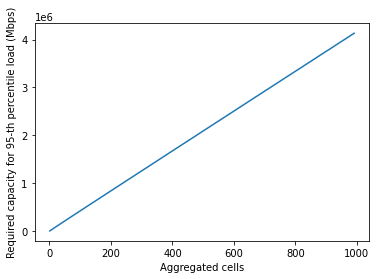

In [87]:
plt.plot(K, req_transp)
plt.xlabel('Aggregated cells')
plt.ylabel('Required capacity for 95-th percentile load (Mbps)')

## Transport network architecture

Based on the 1914.1 Xhaul dimensioning challenges by Faiz Alam from 2018:
* 40 RUs aggregated by a concentrator
  * we need 40 10GE links to the concentrator
  * concentrator will perform statistical multiplexing and produce an output rate of Q(95,K=40) = 
* each concentrator connects to an access FCP, with 20 access FCPs per access ring, therefore the access ring needs $20$
* for every 4 access FCPs we have an access PoP that aggregates
* 5 access PoPs are aggregated by an edge FCP